In [1]:
#!/usr/bin/env python
# coding: utf-8

import argparse
from tqdm import tqdm
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib
from nilearn import datasets, surface
from nilearn.plotting import plot_surf_stat_map

from matplotlib import gridspec
from matplotlib.cm import get_cmap
from matplotlib.colors import Normalize, LinearSegmentedColormap
import itertools

class PlotEncoding():
    def __init__(self, args):
        sid = str(args.s_num).zfill(2)
        process = 'PlotEncoding'
        cmap = sns.color_palette(args.seaborn_palette, as_cmap=True)
        feature = args.feature
        out_dir = args.out_dir
        figure_dir = f'{args.figure_dir}/{process}/sub-{sid}'
        if not os.path.exists(figure_dir):
            os.mkdir(figure_dir)
        fsaverage = datasets.fetch_surf_fsaverage(mesh=args.mesh)





    def _colorbar_from_array(self, array, threshold, cmap):
        """Generate a custom colorbar for an array.
        Internal function used by plot_img_on_surf
        array : np.ndarray
            Any 3D array.
        vmax : float
            upper bound for plotting of stat_map values.
        threshold : float
            If None is given, the colorbar is not thresholded.
            If a number is given, it is used to threshold the colorbar.
            Absolute values lower than threshold are shown in gray.
        kwargs : dict
            Extra arguments passed to _get_colorbar_and_data_ranges.
        cmap : str, optional
            The name of a matplotlib or nilearn colormap.
            Default='cold_hot'.
        """
        vmin = array.min()
        vmax = array.max()
        norm = Normalize(vmin=vmin, vmax=vmax)
        cmaplist = [cmap(i) for i in range(cmap.N)]

        if threshold is None:
            threshold = 0.

        # set colors to grey for absolute values < threshold
        istart = int(vmin)
        istop = int(norm(threshold, clip=True) * (cmap.N - 1))
        for i in range(istart, istop):
            cmaplist[i] = (0.5, 0.5, 0.5, 1.)
        our_cmap = LinearSegmentedColormap.from_list('Custom cmap',
                                                     cmaplist, cmap.N)
        sm = plt.cm.ScalarMappable(cmap=our_cmap,
                                   norm=plt.Normalize(vmin=vmin, vmax=vmax))
        # fake up the array of the scalar mappable.
        sm._A = []

        return sm

    def plot_stats(self, texture,
                   title=None,
                   modes=['lateral', 'medial', 'ventral'],
                   hemis=['left', 'right'],
                   cmap=None, threshold=0.01,
                   output_file=None, colorbar=True,
                   vmax=None, kwargs={}):

        cbar_h = .25
        title_h = .25 * (title is not None)
        w, h = plt.figaspect((len(modes) + cbar_h + title_h) / len(hemis))
        fig = plt.figure(figsize=(w, h), constrained_layout=False)
        height_ratios = [title_h] + [1.] * len(modes) + [cbar_h]
        grid = gridspec.GridSpec(
            len(modes) + 2, len(hemis),
            left=0., right=1., bottom=0., top=1.,
            height_ratios=height_ratios, hspace=0.0, wspace=0.0)
        axes = []
        for i, (mode, hemi) in tqdm(enumerate(itertools.product(modes, hemis)),
                                    total=len(modes)*len(hemis)):
            bg_map = fsaverage['sulc_%s' % hemi]
            ax = fig.add_subplot(grid[i + len(hemis)], projection="3d")
            axes.append(ax)
            plot_surf_stat_map(fsaverage[f'infl_{hemi}'],
                               texture[hemi],
                               view=mode, hemi=hemi,
                               bg_map=bg_map,
                               axes=ax,
                               colorbar=False,  # Colorbar created externally.
                               vmax=vmax,
                               threshold=threshold,
                               cmap=cmap,
                               **kwargs)
            # We increase this value to better position the camera of the
            # 3D projection plot. The default value makes meshes look too small.
            ax.dist = 7

        if colorbar:
            array = np.hstack((texture['left'], texture['right']))
            sm = _colorbar_from_array(array, threshold, get_cmap(cmap))

            cbar_grid = gridspec.GridSpecFromSubplotSpec(3, 3, grid[-1, :])
            cbar_ax = fig.add_subplot(cbar_grid[1])
            axes.append(cbar_ax)
            fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')

        if title is not None:
            fig.suptitle(title, y=1. - title_h / sum(height_ratios), va="bottom")

        if output_file is not None:
            fig.savefig(output_file, bbox_inches="tight")
            plt.close(fig)

    def run(self):
        # load reliability files
        mask = np.load(f'{out_dir}/group_reliability/sub-all_reliability-mask.npy')
        mask_im = nib.load(f'{out_dir}/group_reliability/sub-all_stat-rho_statmap.nii.gz')

        name = f'{out_dir}/VoxelPermutation/sub-{sid}/sub-{sid}_feature-{feature}_rs.npy'
        rs = mkNifti(mask, name, mask_im)

        name = f'{out_dir}/VoxelPermutation/sub-{sid}/sub-{sid}_feature-{feature}_ps.npy'
        ps = mkNifti(mask, name, mask_im, zeros=False)

        texture = {'left': filter_r(rs, ps, hemi='left'),
                   'right': filter_r(rs, ps, hemi='right')}

        name = f'{figure_dir}/sub-{sid}_feature-{feature}.png'
        plot_stats(texture, title=feature.capitalize(),
                        cmap=cmap, output_file=name)


# def main():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--s_num', '-s', type=int)
#     parser.add_argument('--feature', '-f', type=str)
#     parser.add_argument('--mesh', type=str, default='fsaverage5')
#     parser.add_argument('--seaborn_palette', '-palette', type=str, default='magma')
#     parser.add_argument('--out_dir', '-output', type=str, default='/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_analysis/data/interim')
#     parser.add_argument('--figure_dir', '-figure', type=str, default='/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_analysis/reports/figures')
#     args = parser.parse_args()
#     PlotEncoding(args).run()

# if __name__ == '__main__':
#     main()


In [2]:
def filter_r(r, p, hemi, fill=None, crit=5e-2):
    p = surface.vol_to_surf(p, fsaverage[f'pial_{hemi}'])
    
    if fill is None:
        i = np.where(p >= crit)[0]
        r[i] = 0
    else:
        i = np.where(p < crit)[0]
        r[i] += fill
    return r

In [3]:
def mkNifti(mask, name, im, zeros=True):
    if zeros:
        out_im = np.zeros(mask.size)
    else:
        out_im = np.ones(mask.size)
    inds = np.where(mask)[0]
    out_im[inds] = np.load(name)
    return nib.Nifti1Image(out_im.reshape(im.shape), affine=im.affine)

In [4]:
# process = 'components'
top_dir = '/Users/emcmaho7/Dropbox/projects/SI_fmri/SIfMRI_analysis'
data_dir = f'{top_dir}/data/raw'
out_dir = f'{top_dir}/data/interim'
# figure_dir = f'{top_dir}/reports/figures/{process}'
# if not os.path.exists(figure_dir):
#     os.mkdir(figure_dir)
sid='02'
fsaverage = datasets.fetch_surf_fsaverage()

In [5]:
df = pd.read_csv(f'{data_dir}/annotations/annotations.csv')
train = pd.read_csv(f'{data_dir}/annotations/train.csv')
df = df.merge(train)
df.sort_values(by=['video_name'], inplace=True)
features = df.columns.to_list()
features.remove('video_name')

In [6]:
# features_cat = ['visual', 'visual', 'visual',
#                 'visual', 'visual', 'detection',
#                 'detection', 'features', 'features',
#                 'features', 'features', 'features']

features_cat = [1, 1, 1, 1, 1,
                2, 2, 
                3, 3, 3, 3, 3]

In [7]:
mask = np.load(f'{out_dir}/group_reliability/sub-all_reliability-mask.npy')
mask_im = nib.load(f'{out_dir}/group_reliability/sub-all_stat-rho_statmap.nii.gz')

name = f'{out_dir}/VoxelPermutation/sub-{sid}/sub-{sid}_feature-indoor_ps.npy'
ps = mkNifti(mask, name, mask_im, zeros=False)
n = surface.vol_to_surf(ps, fsaverage['pial_right']).shape
texture = {'left': np.zeros(n), 'right': np.zeros(n)}

In [8]:
for feature, cat in zip(features, features_cat):
    name = f'{out_dir}/VoxelPermutation/sub-{sid}/sub-{sid}_feature-{feature}_ps.npy'
    ps = mkNifti(mask, name, mask_im, zeros=False)

    texture = {'left': filter_r(texture['left'], ps, hemi='left', fill=cat),
               'right': filter_r(texture['right'], ps, hemi='right', fill=cat)}

In [9]:
cmap = sns.color_palette("tab10", as_cmap=True)

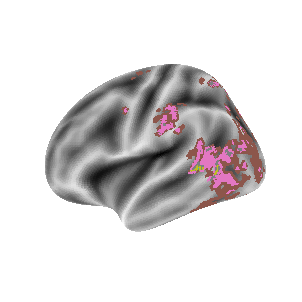

In [10]:
plot_surf_stat_map(fsaverage.infl_left, texture['left'],
                   colorbar=False, cmap=cmap, threshold=0.1,
                   bg_map=fsaverage.sulc_left)
plt.show()